# Predicting Newsletter Subscription through Player Data in Game Research Setting #



## *Introduction* ##
In the world of online gaming, fostering long-term player interest is crucial for building a strong and active community. One strategy developers often rely on is distributing newsletters to keep players informed about game updates, special events, and other relevant news. When a player opts in to receive these newsletters, it usually indicates deeper interest in reamining active within the game.

This project examines whether it is possible to predict newsletter subscription using basic demographics about the players. Data from the analysis was sourced from a Minecraft server managed by a Computer Science research group at UBC, and includes both gameplay metrics and self-reported player characteristics. This combination of data allows to explore potential predictors of sustained player engagement.


To explore different ways of predicting newsletter subscriptions, the **K-Nearest Neighbours (k-NN) classification** model was applied using two distinct strategies. 

- The first model relied solely on the player's self-reported experience level (e.g Beginner, Amateur, Regular, Veteran, Pro).
- The second model incorporated both experience level and number of hours played in-game.


The purpose was to evaluate model performance and assess whether combing a behavioural metric such as playtime with a experience could improve prediction accuracy. Results showed that using only experience level led to moderate accuracy, offering some insight but leaving room for improvement. Accuracy improved, but only marginally after incorporated played hours into the model.

#### Research question ####
Does combining self-reported experience level with playtime lead to better predictions of newsletter subscription than just using experience level alone?

This question aimed to explore whether incorporating a more granular behavioural variable could enhance predictive accuracy beyond what a single categorical feature provides.

#### Data Description ####

The `players` dataset used in the analysis contained 196 player records. Each entry includes:

- `experience`: The player's self-reported experience level -- Beginner, Amateur, Regular, Veteran, Pro
- `subscribe`: Whether or not the player was subscribed to the game's newsletter (TRUE or FALSE)
- `hashedEmail`: The hashed email address of the player
- `played_hours`: The number of hours the player has spent playing
- `name`: Name of the player
- `gender`: Gender of the player
- `age`: The players' age


The data was tidied by encoding categorical variables, handling missing values, and standardizing numerical features. To ensure a consistent and unbiased comparison, both k-NN models underwent tuning and assessed using cross-validation.


## *Methods and Results* ##

First, the required packaged needed for the analysis were loaded in.

In [4]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(forcats)
library(repr)
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


**Part 1: Wrangling and Cleaning Data**

In [7]:
game_data <- read_csv("projectdata/players.csv")
head(game_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


As the variables of interest for the first analysis are `experience` and `subscribe`, those columns were kept, discarding others. Since we want to make a prediction, `experience` was converted from chr to dbl, and `subscribe` was converted to fct to make it predictable.

In [13]:
game_data_select <- game_data |>
    select(experience, subscribe)
game_data_converted <- game_data_select |>
    mutate(experience = case_when(experience == "Pro" ~ 5, experience == "Veteran" ~ 4, experience == "Regular" ~ 3,
                                 experience == "Amateur" ~ 2, experience == "Beginner" ~ 1))

game_data_converted$subscribe <- as.factor(as.integer(game_data_converted$subscribe))
head(game_data_converted)



experience,subscribe
<dbl>,<fct>
5,1
4,1
4,0
2,1
3,1
2,1


**Part 2: Exploratory Data Analysis (EDA)**

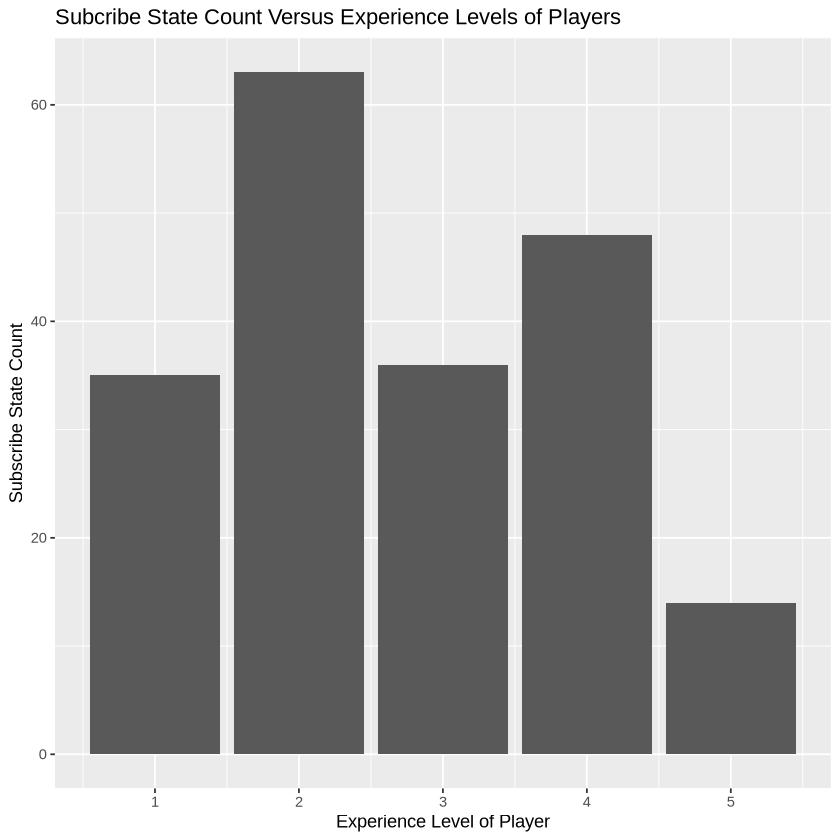

In [14]:
game_data_graph <- game_data_converted |>
    ggplot(aes(x = experience)) +
    geom_bar() +
    xlab("Experience Level of Player") +
    ylab("Subscribe State Count") +
    ggtitle("Subcribe State Count Versus Experience Levels of Players")


game_data_graph

For the second analysis, `played_hours` was incorporated together with `experience`, and the mean playing time of each experience level was summarized.

In [15]:
game_data_2 <- game_data |>
    select(experience, subscribe, played_hours)
head(game_data_2)



experience,subscribe,played_hours
<chr>,<lgl>,<dbl>
Pro,TRUE,30.3
Veteran,TRUE,3.8
Veteran,FALSE,0.0
Amateur,TRUE,0.7
Regular,TRUE,0.1
Amateur,TRUE,0.0


In [11]:
players_data <- game_data_2 |>
    group_by(experience, subscribe) |>
    summarize(mean_hours = mean(played_hours))
head(players_data)

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,subscribe,mean_hours
<chr>,<lgl>,<dbl>
Amateur,FALSE,0.3666667
Amateur,TRUE,8.2777778
Beginner,FALSE,1.1750000
Beginner,TRUE,1.2703704
Pro,FALSE,0.5750000
Pro,TRUE,3.4100000


Below is the visualization of the summary table above, using different colours to indicate the proportion of subscribed and not subscribed players.

List of 2
 $ text :List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 20
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ title: chr "Average Play Level"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

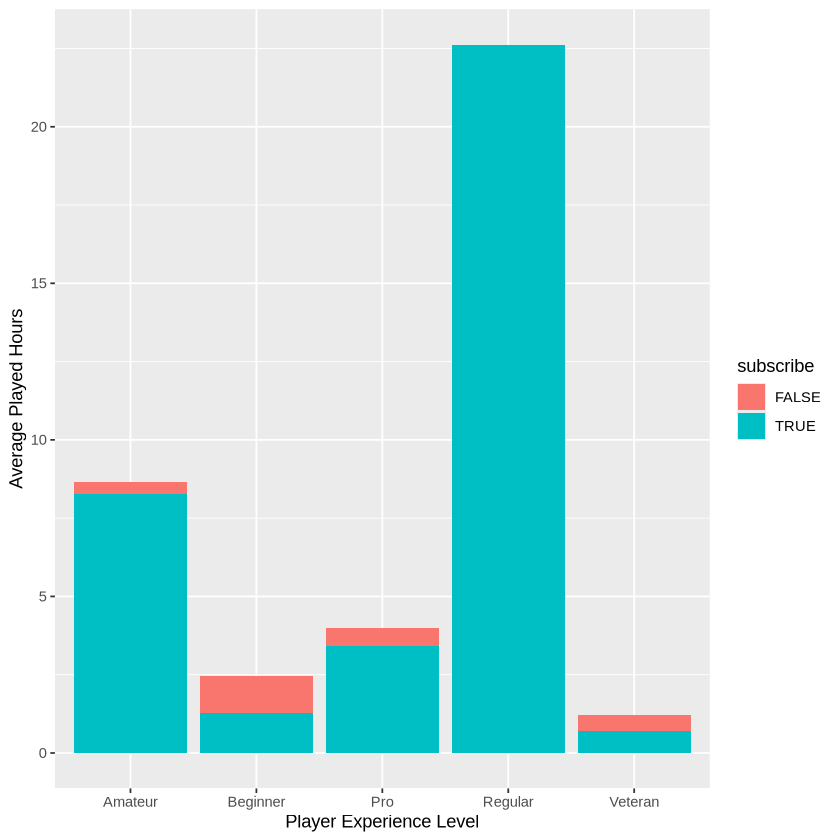

In [21]:
player_data_plot <- players_data |>
    ggplot(aes(x = experience, y = mean_hours, fill = subscribe)) +
    geom_bar(stat = "identity") +
    labs(x = "Player Experience Level", y = "Average Played Hours", color = "Subscribed?")
    theme(text = element_text(size = 20)) +
    ggtitle("Average Play Level") 

player_data_plot

**K- Nearest Neighbors (k-NN) Classification Modeling**

Since the goal is to predict subscribe states of the players, KNN classification was used the model to perform the prediction. It begins by splitting the dataset into a training and testing set.

In [54]:
set.seed(123)
game_split <- game_data_converted |>
    initial_split(prop = 0.75, strata = subscribe)
game_training <- training(game_split) 
game_testing <- testing(game_split)

The code below builds and tunes a KNN classification model to predict newsletter subscription using only the experience variable. it uses a 5-fold cross-validation to evaluate model performance across a range of k values, and results are filtered to show an accuracy score for each k.

In [73]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

game_recipe <- recipe(subscribe ~ experience, data = game_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
game_cv_folds <- vfold_cv(game_training, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() |>
    add_recipe(game_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = game_cv_folds, grid = k_vals) |>
    collect_metrics() 

accuracies <- knn_results |>
    filter(.metric == "accuracy") 
head(accuracies)



    

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.3122989,5,0.02024555,Preprocessor1_Model01
2,accuracy,binary,0.3122989,5,0.02024555,Preprocessor1_Model02
3,accuracy,binary,0.3122989,5,0.02024555,Preprocessor1_Model03
4,accuracy,binary,0.2718391,5,0.00818436,Preprocessor1_Model04
5,accuracy,binary,0.3056322,5,0.01652576,Preprocessor1_Model05
6,accuracy,binary,0.3122989,5,0.02024555,Preprocessor1_Model06


The best k value is chosen by selecting a k value that corresponds to the highest accuracy value.

In [74]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 27

In [105]:
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                                    neighbors = 27) |>
    set_engine("kknn") |>
    set_mode("classification") 

final_fit <- workflow() |>
    add_recipe(game_recipe) |>
    add_model(best_knn_spec) |>
    fit(data = game_training)

subscribe_predictions <- predict(final_fit, game_testing) |>
    bind_cols(game_testing)

test_metrics <- subscribe_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)
conf_matrix <- subscribe_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
test_metrics
conf_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.61224490
kap,binary,-0.01971522


          Truth
Prediction  0  1
         0  3  9
         1 10 27

According to the prediction chart above, the model achieved a moderate accuracy of 61%, offering some insight but leaving room for improvement as the model uses a single discrete predictor. To try to improve the model, another one was built using two predictors, one being numerical (`play_hours`).

In [90]:
game_data_2 <- game_data |>
    select(experience, played_hours, subscribe)

game_data_converted_2 <- game_data_2 |>
    mutate(experience = case_when(experience == "Pro" ~ 5, experience == "Veteran" ~ 4, experience == "Regular" ~ 3,
                                 experience == "Amateur" ~ 2, experience == "Beginner" ~ 1))

game_data_converted_2$subscribe <- as.factor(as.integer(game_data_converted_2$subscribe))
head(game_data_converted_2)



experience,played_hours,subscribe
<dbl>,<dbl>,<fct>
5,30.3,1
4,3.8,1
4,0.0,0
2,0.7,1
3,0.1,1
2,0.0,1


Again, the data set was split into training and testing sets.

In [93]:
set.seed(1234)
game_split_2 <- game_data_converted_2 |>
initial_split(prop = 0.75, strata = subscribe)

game_training_2 <- training(game_split_2)
game_testing_2 <- testing(game_split_2)

The k-NN classification model was used again, similar to the last analysis except using an additional predictor, played_hours. k value was chosen again by selecting the one that yielded the highest accuracy.

In [99]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

game_recipe_2 <- recipe(subscribe ~ experience + played_hours, data = game_training_2)

game_cv_folds_2 <- vfold_cv(game_training_2, v = 5, strata = subscribe)

knn_results_2 <- workflow() |>
    add_recipe(game_recipe_2) |>
    add_model(knn_spec_2) |>
    tune_grid(resamples = game_cv_folds_2, grid = k_vals) |>
    collect_metrics() 

accuracies_2 <- knn_results_2 |>
    filter(.metric == "accuracy") 
head(accuracies_2)


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4825123,5,0.02998112,Preprocessor1_Model01
2,accuracy,binary,0.4965517,5,0.03181023,Preprocessor1_Model02
3,accuracy,binary,0.5170115,5,0.02593324,Preprocessor1_Model03
4,accuracy,binary,0.5032020,5,0.03118909,Preprocessor1_Model04
5,accuracy,binary,0.5572414,5,0.03157344,Preprocessor1_Model05
6,accuracy,binary,0.5365353,5,0.03840506,Preprocessor1_Model06


In [101]:
best_k_2 <- accuracies_2 |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k_2

[1] 18

In [104]:
best_knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", 
                                    neighbors = 18) |>
    set_engine("kknn") |>
    set_mode("classification") 

final_fit_2 <- workflow() |>
    add_recipe(game_recipe_2) |>
    add_model(best_knn_spec_2) |>
    fit(data = game_training_2)

subscribe_predictions_2 <- predict(final_fit_2, game_testing_2) |>
    bind_cols(game_testing_2)

test_metrics_2 <- subscribe_predictions_2 |>
    metrics(truth = subscribe, estimate = .pred_class)
conf_matrix_2 <- subscribe_predictions_2 |>
    conf_mat(truth = subscribe, estimate = .pred_class)
test_metrics_2
conf_matrix_2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776
kap,binary,0.0516129


          Truth
Prediction  0  1
         0  2  4
         1 11 32

## *Summary* ##

This project investigated whether combining self-reported and behavioural data could improv prediction accuracy of newsletter subscription among players of an online game. Two k-Nearest Neighbors (k-NN) classification models were developed -- one using the categorical variable experience, another incorporating both experience and numeric feature played_hours, which captures total in-game time.

The model that was based solely on experienced performed modest success in predction, likely because this self-assessed category is too broad and lacks precision. Adding `played_hours` to the model resulted in only a slight improvement in accuracy from 61% to 69%, suggesting that while behavioural data holds potential, basic measures like total playing time may not be sufficient on its own. Nonetheless, the results support the broader idea that behavioural variables tend to offer more actionable insight than self-reported traits alone, particularly for predicting engagement.

#### Was This Outcome Expected? ####
Partially. It was anticipated that adding a behavioural feature like played hours would boost model performance, but the actual improvement found was minimal. This highlights the limitations of using categorial data in isolation, while also revealing that not all behavioural metrics are equally informative either. While experience refelcts how players perceive their skill, it may not reliably correspond to actual in-game activity. Meanwhile, played_hours, although grounded in behaviour, may need to be paired with richer contextual data to be truly useful.

#### What Impacts Could These Findings Have? ####
The findings of this analysis suggest that engagement prediction can be enhanced with carefully selected behavioural data. For developers and researchers, simple metrics like time played can offer a good starting point for indentifying patterns of interest, but more nuanced behavioural indicators may be needed for more accurate predictions. Insights like these can inform how game developers design engagement strategies, expecially when using newsletters or other in-game incentives. 

#### What Future Questions Could This Lead To? ####
- What behavioural features are most predictive of player engagement? -- For example, do the playing session length or time of day played offer more predictive power than total hours?
- Do behavioural patterns vary across player types or demographics? -- Are different features more predictive for new vs. experienced players, or casual vs. competitive players?
- How would combining multiple behavioural variables affect prediction accuracy? -- Would combining `played_hours` with some other metric like in-game purchases or achievement completion create a stronger model?
